# Importing Libraries

In [ ]:
# Data manipulation and analysis libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations and arrays

# Image processing libraries
from PIL import Image          # Python Imaging Library for opening/manipulating images
import matplotlib.pyplot as plt # For plotting and visualization

# System and utility libraries
import time  # For timing operations and adding delays

# PyTorch deep learning framework and its components
import torch                    # Main PyTorch library
import torch.nn as nn          # Neural network modules
import torch.nn.functional as F # Neural network functions
import torch.optim as optim    # Optimization algorithms
from torch.optim import lr_scheduler        # Learning rate scheduling
from torchvision import models             # Pre-trained models
from torchvision.datasets import ImageFolder # Dataset class for images
import torchsummary                        # For model architecture visualization

# PyTorch data handling utilities
from torch.utils.data.sampler import SubsetRandomSampler # For random sampling
from torch.utils.data import Dataset      # Base dataset class
from torch.utils.data import DataLoader   # For batch loading

# Data augmentation and transformation utilities
import torchvision                        # Computer vision library
from torchvision import datasets, models, transforms, utils # Vision utilities
from torchvision.transforms import v2     # Latest transform operations

# Additional utilities and ML libraries
import cv2                     # OpenCV for image processing
import os                      # Operating system interface
from glob import glob         # File pattern matching
from tqdm import tqdm         # Progress bar
import shutil                 # File operations
from sklearn.model_selection import train_test_split, KFold  # For splitting datasets
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report # For model evaluation
import seaborn as sns         # Statistical data visualization


# Download Dataset

In [20]:
#!/bin/bash
! curl -L -o ~/Downloads/gender-detection-and-classification-image-dataset.zip\
https://www.kaggle.com/api/v1/datasets/download/trainingdatapro/gender-detection-and-classification-image-dataset


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  605M  100  605M    0     0  2239k      0  0:04:36  0:04:36 --:--:-- 2423k  0  0:07:39  0:00:07  0:07:32 1905k37  0:00:22  0:04:15 2883k  0:03:52 2707k  0  2333k      0  0:04:25  0:00:33  0:03:52 2225k3  144M    0     0  2116k      0  0:04:53  0:01:09  0:03:44 1331k2k      0  0:05:29  0:01:39  0:03:50 1529k011k 3006k0  0:03:10  0:01:30 2348k03:15  0:01:26 2124k1:14 2749k:04 2185k9  0:03:38  0:01:01 1048k4:40  0:04:10  0:00:30 1945k18k      0  0:04:39  0:04:17  0:00:22 2557k


# Importing Dataset

In [23]:
# Initialize empty DataFrame with columns for image path, label and class ID
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})

# Set path to training data directory
train_path = 'Data/train'

# Define list of class labels for gender classification
label_list = [
    'men',   # class_id = 0 
    'women', # class_id = 1
]

# Iterate through each gender label and corresponding index
for i, label in enumerate(label_list):
    # Construct full path to images for current gender
    img_path = os.path.join(train_path, label)
    # Get list of all jpg images in the gender folder
    img_list = glob(img_path+'/*.jpg')
    # Process each image file
    for img in img_list:
        # Create DataFrame row with image path, label and class ID
        new_data =pd.DataFrame({"path":img,"label":label, "class_id":i}, index=[1])
        # Append row to main DataFrame
        df = pd.concat([df, new_data], ignore_index=True)

# Convert DataFrame columns to appropriate data types
df[["path"]] = df[["path"]].astype(str)     # Path as string
df[["label"]] = df[["label"]].astype(str)   # Label as string  
df[["class_id"]] = df[["class_id"]].astype(int) # Class ID as integer


In [24]:
df.head()


,path,label,class_id
0,Data/train/men/63.jpg,men,0
1,Data/train/men/77.jpg,men,0
2,Data/train/men/88.jpg,men,0
3,Data/train/men/89.jpg,men,0
4,Data/train/men/76.jpg,men,0


In [25]:
df.tail()


,path,label,class_id
215,Data/train/women/91.jpg,women,1
216,Data/train/women/85.jpg,women,1
217,Data/train/women/52.jpg,women,1
218,Data/train/women/0.jpg,women,1
219,Data/train/women/46.jpg,women,1


# Plotting Distribution of Men and Women

This is done to see if the dataset is not imbalanced

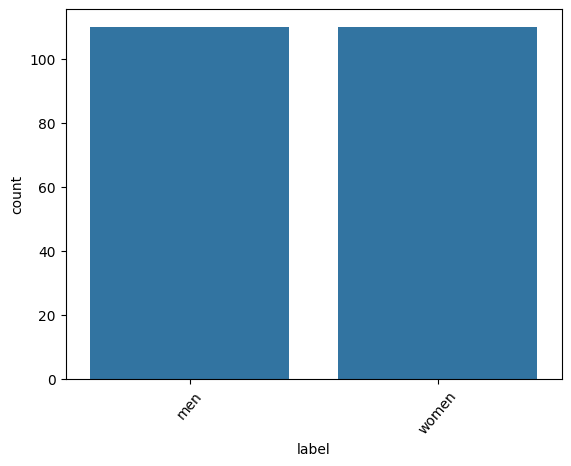

In [26]:
sns.countplot(x = df["label"])
plt.xticks(rotation = 50);


# Plotting Random Images from the Dataset

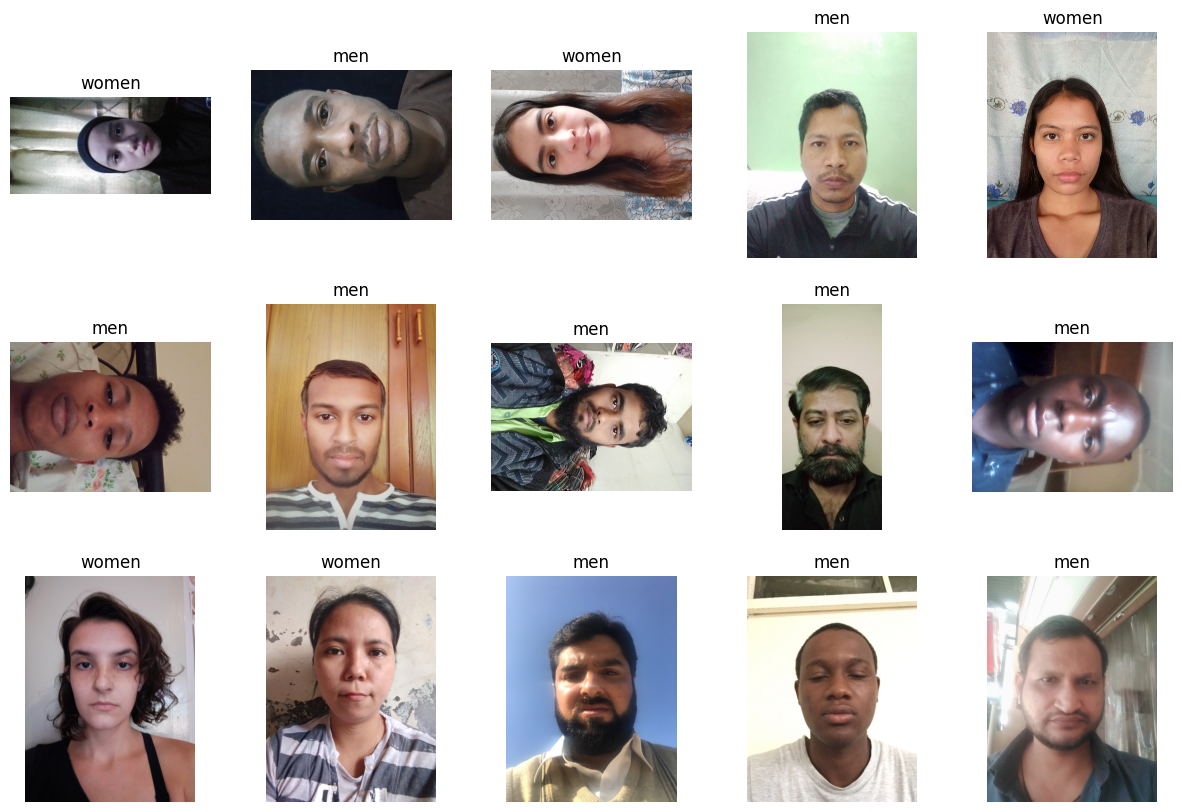

In [27]:
# Number of random images to display
show_imgs = 15

# Generate random indices to select images from the dataset
idx = np.random.randint(0, len(df),size=show_imgs)

# Create a figure with subplots arranged in 3 rows and 5 columns
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))

# Flatten the 2D array of axes into 1D for easier iteration
axes = axes.flatten()

# Iterate through each subplot axis
for i, ax in enumerate(axes):
    # Get the full file path for the randomly selected image
    full_path = df.loc[idx[i]]['path']
    
    # Display the image in the current subplot
    ax.imshow(plt.imread(full_path))
    
    # Set the subplot title to show the gender label
    ax.set_title(df.loc[idx[i]]['label'])
    
    # Remove axis ticks and labels for cleaner visualization
    ax.set_axis_off()


# Image Augmentation for both train and test data

In [28]:
# Define augmentation transforms for training data
train_transforms = v2.Compose([
    v2.Resize(256),                                              # Resize image to 256x256
    v2.RandomResizedCrop(size=(224, 224), antialias=True),      # Randomly crop and resize to 224x224 with antialiasing
    v2.RandomHorizontalFlip(p=0.5),                             # 50% chance to flip image horizontally
    v2.RandomVerticalFlip(p=0.5),                               # 50% chance to flip image vertically
    # v2.RandomRotation(degrees=(-20, 20)),                     # Commented out random rotation
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transformation with rotation, translation and scaling
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),                 # 50% chance to randomly erase rectangular patches
    v2.PILToTensor(),                                           # Convert PIL image to tensor
    v2.ToDtype(torch.float32),                                  # Convert tensor to float32
    v2.Normalize(mean=[0.485, 0.456, 0.406],                   # Normalize using ImageNet statistics
                std=[0.229, 0.224, 0.225]),                     # Standard deviation values for normalization
])

# Define simpler transforms for test/validation data (no augmentation)
test_transforms = v2.Compose([
    v2.Resize((224,224)),                                       # Resize image to 224x224
    v2.PILToTensor(),                                           # Convert PIL image to tensor
    v2.ToDtype(torch.float32),                                  # Convert tensor to float32
    v2.Normalize(mean=[0.485, 0.456, 0.406],                   # Normalize using ImageNet statistics
                std=[0.229, 0.224, 0.225])                      # Standard deviation values for normalization
])


# Converting PIL images to torch tensors

In [29]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        """
        Initialize the dataset with a dataframe containing image paths and labels, and transforms to apply
        
        Args:
            dataframe: Pandas DataFrame containing 'path' and 'class_id' columns
            transforms_: Composition of image transforms to apply (augmentation, tensor conversion etc.)
        """
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        """
        Return the total number of samples in the dataset
        
        Returns:
            int: Number of samples
        """
        return len(self.df)

    def __getitem__(self, index):
        """
        Get a single sample from the dataset
        
        Args:
            index: Integer index of the sample to retrieve
            
        Returns:
            tuple: (transformed_image_tensor, class_label)
                - transformed_image_tensor: Image tensor after applying transforms
                - class_label: Integer class ID (0 for men, 1 for women)
        """
        # Get the image path from the dataframe
        image_path = self.df.iloc[index]['path']
        
        # Open image and convert to RGB format
        # Note: Previous attempts used LA (grayscale+alpha) and plain RGB formats
        img = Image.open(image_path).convert("RGB")
        
        # Apply the transforms pipeline to the image
        transformed_img = self.transforms_(img)
        
        # Get the class ID from the dataframe
        class_id = self.df.iloc[index]['class_id']
        
        return transformed_img, class_id


# Check if GPU is available and set the device accordingly

In [ ]:
# Check if GPU is available and set the device accordingly
# If CUDA-enabled GPU is available, use it; otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set number of worker processes for data loading
# Use 2 workers for GPU to prevent bottlenecking, 4 for CPU
# This is optimized for Kaggle notebook environment
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook

# Split the dataset into training and validation sets
# 80% for training, 20% for validation
# Random state ensures reproducible splits
train_df, val_df = train_test_split(df, test_size=0.2,random_state=9898)

# Create dataset objects for training and validation
# train_transforms includes data augmentation
# test_transforms only includes normalization and tensor conversion
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

# Set batch size for training
BATCH_SIZE = 16

# Create data loaders for both training and validation sets
# Training loader shuffles data to prevent model from learning order dependencies
# Validation loader doesn't need shuffling
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [38]:
print(f'train data: {len(train_df)}')
print(f'val data: {len(val_df)}')


train data: 176
val data: 44


In [ ]:
# Get number of unique classes from label list
# Alternative approach: class_size = len(df['label'].unique())
class_size = len(label_list)

# Initialize EfficientNetV2-Small model with pretrained weights
model = models.efficientnet_v2_s(weights='DEFAULT')

# Replace the final classifier layer to match our number of classes
# EfficientNetV2-S has 1280 features in final layer before classification
model.classifier[1] = torch.nn.Linear(1280, class_size)

# Alternative model architecture (currently commented out):
# Initialize Swin Transformer V2-Small with pretrained weights
# model = models.swin_v2_s(weights='DEFAULT')
# Replace classification head to match our number of classes
# model.head = nn.Linear(in_features=model.head.in_features, out_features=class_size)

# Test the model with a random input tensor to verify output shape
# Input shape: (batch_size=16, channels=3, height=224, width=224)
# Returns shape of model output to verify dimensions
model(torch.randn((16,3,224,224))).shape


torch.Size([16, 2])

# Train the model

In [40]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    # Get total number of samples in dataset
    size = len(dataloader.dataset) # number of samples
    # Get number of batches per epoch based on batch size
    num_batches = len(dataloader) # batches per epoch
    # Set model to training mode - enables dropout, batch norm etc.
    model.train()
    # Initialize running loss and accuracy metrics for this epoch
    epoch_loss = 0.0
    epoch_correct = 0
    # Iterate through batches of data
    for (data_,target_) in dataloader:
        # Convert target labels to LongTensor type required for classification
        target_ = target_.type(torch.LongTensor)
        # Move data and targets to GPU if available
        data_, target_ = data_.to(device), target_.to(device)

        # Zero out parameter gradients from previous batch
        # This prevents gradient accumulation between batches
        optimizer.zero_grad()

        # Forward pass - get model predictions
        outputs = model(data_)

        # Calculate loss between predictions and ground truth
        loss = loss_fn(outputs,target_)

        # Backward pass - compute gradients of loss w.r.t. parameters
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Accumulate batch statistics for epoch-level metrics
        epoch_loss = epoch_loss + loss.item()  # Add batch loss
        _,pred = torch.max(outputs,dim=1)      # Get predicted class indices
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()  # Count correct predictions
    
    # Update learning rate according to schedule
    lr_scheduler.step()
    # Return accuracy (correct/total) and average loss for the epoch
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    # Get dataset size and number of batches
    size = len(dataloader.dataset) # number of samples  
    num_batches = len(dataloader) # batches per epoch
    # Initialize metrics for validation
    epoch_loss = 0.0
    epoch_correct = 0
    
    # Disable gradient computation for validation
    with torch.no_grad():
        # Set model to evaluation mode - disables dropout etc.
        model.eval()
        # Iterate through validation data
        for (data_,target_) in dataloader:
            # Convert targets to correct type and move to device
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Get model predictions
            outputs = model(data_)

            # Calculate validation loss
            loss = loss_fn(outputs,target_)
            
            # Accumulate validation metrics
            epoch_loss = epoch_loss + loss.item()  # Add batch loss
            _,pred = torch.max(outputs,dim=1)      # Get predicted classes
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()  # Count correct predictions
    
    # Return validation accuracy and average loss
    return  epoch_correct/size, epoch_loss/num_batches


In [41]:
# Move model to GPU/CPU device
model.to(device)

# Number of training epochs
EPOCHS = 5

# Dictionary to store training and validation metrics
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

# Create checkpoints directory if it doesn't exist
if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

# Loss function - Cross Entropy Loss for classification
criterion  = nn.CrossEntropyLoss()

# Hyperparameters for optimizer
learning_rate = 0.0001
momentum = 0.9  
weight_decay = 0.1

# Initialize AdamW optimizer with learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler milestones and initialization
lr_milestones = [7, 14, 21, 28, 35]  # Epochs at which to reduce learning rate
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement before stopping
counter = 0   # Counter for epochs without improvement
best_loss = np.inf  # Initialize best validation loss as infinity

# Training loop
for epoch in tqdm(range(EPOCHS)):
    # Train one epoch and get metrics
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    
    # Validate model and get metrics
    val_acc, val_loss = test(val_loader, model, criterion)
    
    # Print epoch results
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    # Store metrics in logs
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    
    # Save latest model checkpoint
    torch.save(model.state_dict(), "checkpoints/last.pth")
    
    # Early stopping logic
    if val_loss < best_loss:
        counter = 0  # Reset counter if model improved
        best_loss = val_loss  # Update best loss
        torch.save(model.state_dict(), "checkpoints/best.pth")  # Save best model
    else:
        counter += 1  # Increment counter if no improvement
        
    # Stop training if no improvement for patience epochs
    if counter >= patience:
        print("Earlystop!")
        break


  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.6927, train_acc: 0.500     val_loss: 0.7327, val_acc: 0.432     Learning Rate: 0.0001


 40%|████      | 2/5 [06:08<09:16, 185.63s/it]

EPOCH: 1     train_loss: 0.6154, train_acc: 0.665     val_loss: 0.6583, val_acc: 0.545     Learning Rate: 0.0001
EPOCH: 2     train_loss: 0.5254, train_acc: 0.812     val_loss: 0.5181, val_acc: 0.750     Learning Rate: 0.0001


 60%|██████    | 3/5 [09:21<06:18, 189.11s/it]

EPOCH: 3     train_loss: 0.4595, train_acc: 0.795     val_loss: 0.3260, val_acc: 0.932     Learning Rate: 0.0001


 80%|████████  | 4/5 [12:37<03:11, 191.89s/it]

EPOCH: 4     train_loss: 0.4274, train_acc: 0.830     val_loss: 0.2463, val_acc: 0.909     Learning Rate: 0.0001


100%|██████████| 5/5 [16:43<00:00, 200.64s/it]


# Plotting the training and validation loss and accuracy

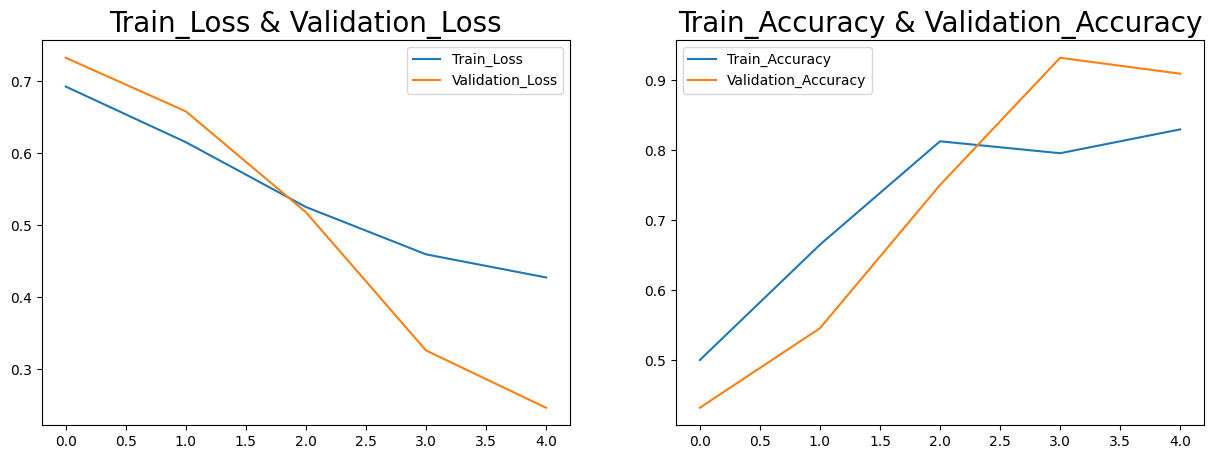

In [42]:
# Create a figure with size 15x5 inches to hold two subplots side by side
plt.figure(figsize=(15,5))

# Create first subplot for loss curves
plt.subplot(1,2,1)  # 1 row, 2 columns, first subplot
plt.plot(logs['train_loss'],label='Train_Loss')  # Plot training loss curve
plt.plot(logs['val_loss'],label='Validation_Loss')  # Plot validation loss curve
plt.title('Train_Loss & Validation_Loss',fontsize=20)  # Add title with font size 20
plt.legend()  # Show legend with curve labels

# Create second subplot for accuracy curves  
plt.subplot(1,2,2)  # 1 row, 2 columns, second subplot
plt.plot(logs['train_acc'],label='Train_Accuracy')  # Plot training accuracy curve
plt.plot(logs['val_acc'],label='Validation_Accuracy')  # Plot validation accuracy curve
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)  # Add title with font size 20
plt.legend()  # Show legend with curve labels


# Testing the model

In [43]:
# Initialize empty DataFrame to store test data with columns for image path, label and class ID
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})

# Set path to test data directory
test_path = 'Data/test'

# Define list of class labels
label_list = [
    'men',
    'women',
    ]

# Iterate through each class label and its index
for i, label in enumerate(label_list):
    # Construct full path to class directory
    img_path = os.path.join(test_path, label)
    # Get list of all jpg images in class directory
    img_list = glob(img_path+'/*.jpg')
    # For each image in the class
    for img in img_list:
        # Create DataFrame with single image data
        new_data =pd.DataFrame({"path":img,"label":label, "class_id":i}, index=[1])
        # Append to main test DataFrame
        test_df = pd.concat([test_df, new_data], ignore_index=True)

# Convert DataFrame columns to appropriate data types
test_df[["path"]] = test_df[["path"]].astype(str)  # Convert paths to strings
test_df[["label"]] = test_df[["label"]].astype(str)  # Convert labels to strings  
test_df[["class_id"]] = test_df[["class_id"]].astype(int)  # Convert class IDs to integers

# Create test dataset and dataloader
test_dataset = MyDataset(val_df, test_transforms)  # Create dataset with validation transforms
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)  # Create DataLoader with batch size


# Load the best Model and make Predictions

In [44]:
# Load the best saved model weights from checkpoint file
model.load_state_dict(torch.load('checkpoints/best.pth'))

# Set model to evaluation mode (disables dropout, batch norm, etc)
model.eval()

# Initialize empty lists to store true labels and predicted labels
y_true, y_pred = [], []

# Disable gradient calculation since we're only doing inference
with torch.no_grad():
    # Iterate through test data batches with progress bar
    for (data_,target_) in tqdm(test_loader):
        # Convert target labels to LongTensor type
        target_ = target_.type(torch.LongTensor)
        
        # Move input data and target labels to GPU/CPU device
        data_, target_ = data_.to(device), target_.to(device)
        
        # Get model predictions for current batch
        outputs = model(data_)
        
        # Get predicted class (index of maximum probability)
        _,pred = torch.max(outputs,dim=1)
        
        # Add true labels and predictions to lists after moving back to CPU
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# Convert prediction lists to numpy arrays for evaluation
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 3/3 [00:07<00:00,  2.66s/it]


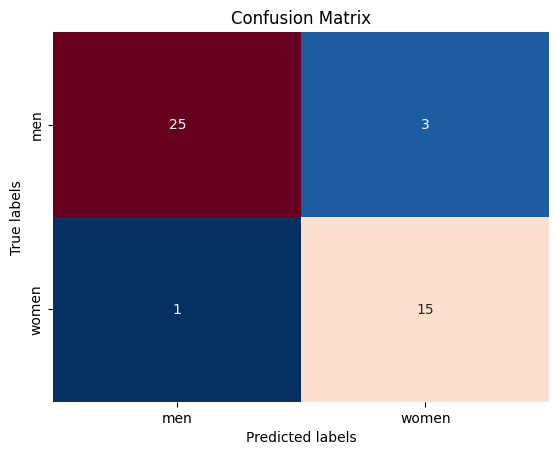

In [45]:
# Create a new subplot for the confusion matrix visualization
ax= plt.subplot()

# Calculate the confusion matrix using true and predicted labels
CM = confusion_matrix(y_true,y_pred)

# Create a heatmap visualization of the confusion matrix
# annot=True shows the numerical values in each cell
# fmt='g' formats the numbers as integers
# cbar=False removes the color bar
# cmap='RdBu_r' uses a red-blue color scheme
# xticklabels and yticklabels use the class names from label_list
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)

# Add labels and title to the plot
ax.set_xlabel('Predicted labels')  # X-axis shows predicted classes
ax.set_ylabel('True labels')       # Y-axis shows actual classes
ax.set_title('Confusion Matrix')   # Set the plot title

# Display the confusion matrix plot
plt.show()


In [46]:
# Generate a detailed classification report showing precision, recall, f1-score and support for each class
# y_true: array of actual/true labels from the test set
# y_pred: array of predicted labels from our model
# target_names: list of class names (men, women) for readable output
clf_report = classification_report(y_true, y_pred, target_names = label_list)

# Print the classification report showing model performance metrics for each class
# This will display:
# - Precision: ratio of correct positive predictions to total positive predictions
# - Recall: ratio of correct positive predictions to all actual positives
# - F1-score: harmonic mean of precision and recall
# - Support: number of samples for each class
print(clf_report)


              precision    recall  f1-score   support

         men       0.96      0.89      0.93        28
       women       0.83      0.94      0.88        16

    accuracy                           0.91        44
   macro avg       0.90      0.92      0.90        44
weighted avg       0.91      0.91      0.91        44

